In [1]:
import SimDAT2D as sim
import numpy as np
import numpy.ma as ma
import numpy.random as rnd
import matplotlib.pyplot as plt
import pyFAI
import pyFAI.azimuthalIntegrator as AI
import os
import pandas as pd
import dask
from dask import delayed

In [2]:
def slice_mask(chi, width, plot = False):
    ''' Returns a mask that has one slice of the chi array left unmasked to be used for integration.

    Keyword arguments:
    chi -- chi array 
    width -- width of the slice in degrees
    plot -- if True, plots the mask (default False)
    '''
    #creating the mask and setting the first width pixels to False to leave a slice of width pixels unmasked
    mask = np.ma.masked_outside(chi, 0, width)
    
    if plot == True:
        plt.figure()
        plt.imshow(mask, cmap='magma')
    
    return mask

In [3]:
def make_chi_array(tiff, dist, wavelength):
    ''' Returns a chi array from a tiff file.
    
    Keyword arguments:
    tiff -- tiff file
    dist -- distance from the sample to the detector
    wavelength -- wavelength of the x-rays
    '''
    
    #creating the detector object and calculating the cartesian positions
    dete = pyFAI.detectors.Perkin()
    p1, p2, p3 = dete.calc_cartesian_positions()
    poni1 = p1.mean()
    poni2 = p2.mean()
    
    #creating the azimuthal integrator object
    ai_pe = AI.AzimuthalIntegrator(dist=dist, wavelength=wavelength, poni1=poni1, poni2=poni2, detector=dete)
    
    #creating the chi array
    chi_array = np.degrees(ai_pe.chiArray())
    
    return chi_array

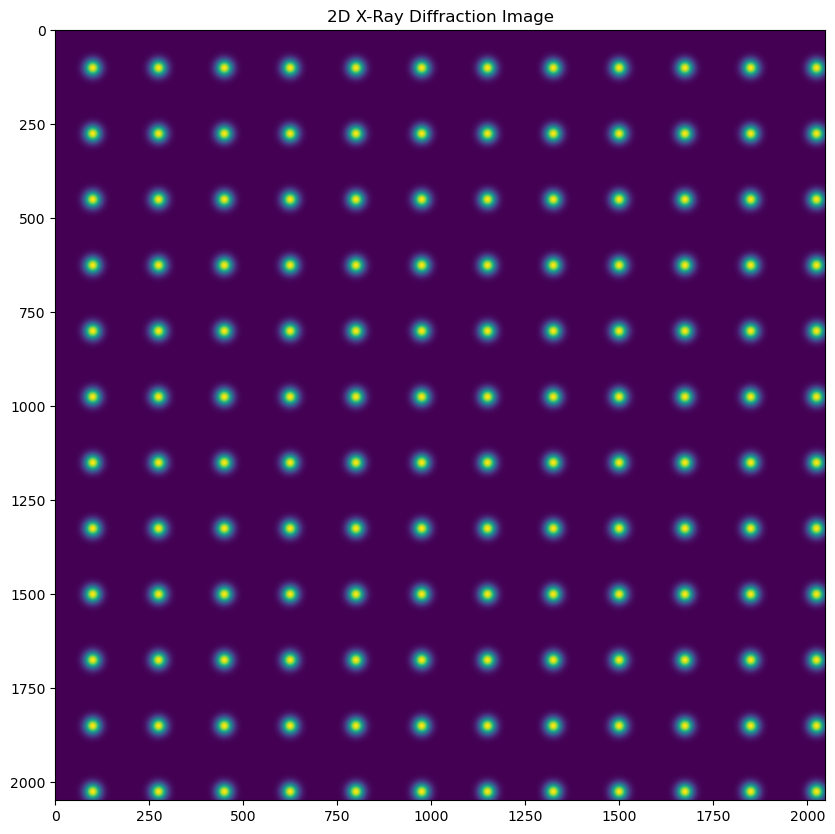

Select calibrant:
1. AgBh
2. Al
3. alpha_Al2O3
4. Au
5. C14H30O
6. CeO2
7. Cr2O3
8. cristobaltite
9. CrOx
10. CuO
11. hydrocerussite
12. LaB6
13. LaB6_SRM660a
14. LaB6_SRM660b
15. LaB6_SRM660c
16. mock
17. NaCl
18. Ni
19. PBBA
20. Pt
21. quartz
22. Si
23. Si_SRM640
24. Si_SRM640a
25. Si_SRM640b
26. Si_SRM640c
27. Si_SRM640d
28. Si_SRM640e
29. TiO2
30. ZnO
LaB6_SRM660a


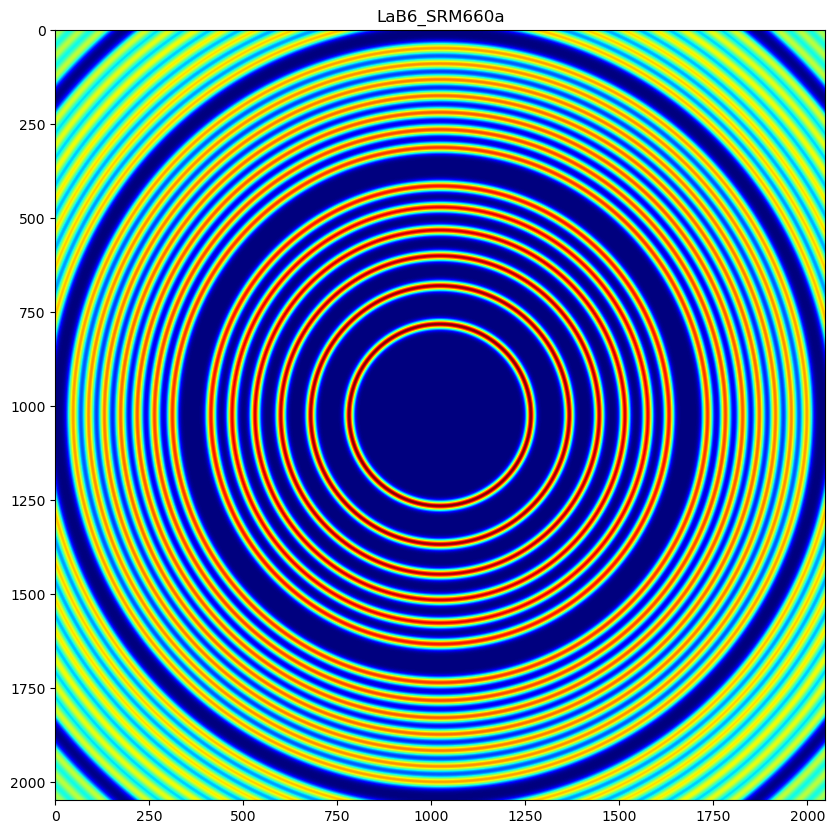

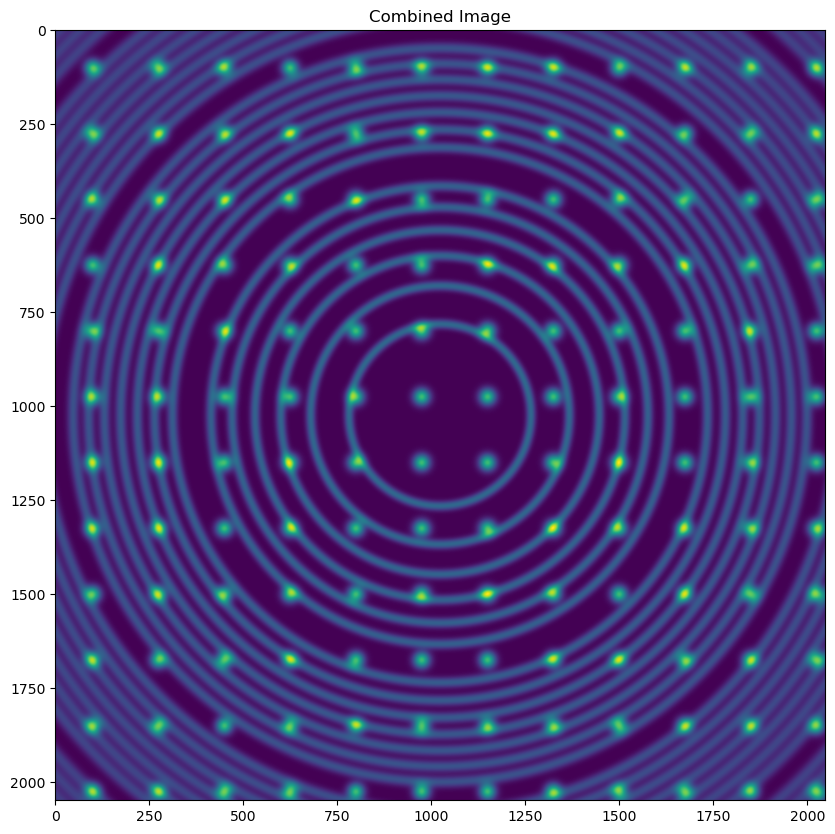

In [4]:
my_tiff = sim.combine_image((sim.create_anisotropic(25, 15, 175, size = 200)*2), sim.create_isotropic(.4, .5e-10, cmap = 'jet'))

In [5]:
chi_array = make_chi_array(my_tiff, 0.4, 0.5e-10)

In [6]:
chi_array.max()

179.9719970540696

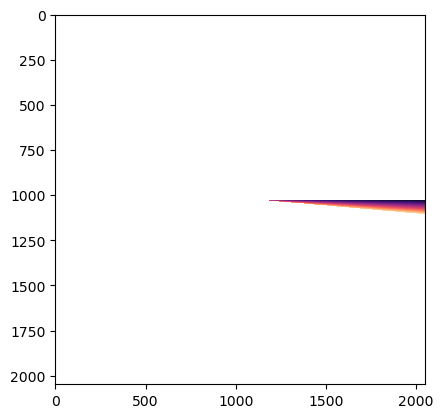

In [7]:
my_mask = slice_mask(chi_array, 5, plot = True)

In [10]:
def rotate_mask_360(chi_array, width, rot_degree = 1, plot = False):
    ''' Rotates a mask 360 degrees around the center of the mask.
    
    Keyword arguments:
    mask -- mask to be rotated
    chi_array -- chi array to be used for the rotation
    '''
    #creating a list of angles to rotate the mask
    
    positive_angles = np.arange(0, 179, rot_degree)
    negative_angles = np.arange(-179, 0, rot_degree)
    
    #creating a list of rotated masks
    rotated_masks = []
    
    #rotating the mask and appending it to the list of rotated masks
    for angle in positive_angles:
        rotated_masks.append(np.ma.masked_outside(chi_array,0+angle, width+angle))
        
        if plot == True:
            plt.figure()
            plt.imshow(rotated_masks[-1], cmap = 'magma')
        
    for angle in negative_angles:
        rotated_masks.append(np.ma.masked_outside(chi_array,0+angle, width+angle))
        
        if plot == True:
            plt.figure()
            plt.imshow(rotated_masks[-1], cmap = 'magma')
    
    return rotated_masks

In [11]:
rotated_masks = rotate_mask_360(chi_array, .5, rot_degree = .9)

MemoryError: Unable to allocate 32.0 MiB for an array with shape (2048, 2048) and data type float64

In [ ]:
len(rotated_masks)

358

In [10]:
def multiple_slice_mask(array, width, num, offset = 30, plot = False):
    ''' Returns a mask with multiple slices of the chi array left unmasked to be used for integration.
    
    Keyword arguments:
    chi_array -- chi array 
    width -- width of the slice in degrees
    num -- number of slices
    plot -- if True, plots the masks (default False)
    '''
    #creating the mask and setting the first width pixels to False to leave a slice of width pixels unmasked
                                
    mask_list = []
    
    # Create masks for the positive values
    for i in range(num):
        start = i * (width + offset)
        end = start + width
        mask_list.append(ma.masked_outside(array, start, end))

    # Create masks for the negative values
    for i in range(num):
        start = - (i + 1) * (width + offset)
        end = start - width
        mask_list.append(ma.masked_outside(array, start, end))
    
    #add all genrated masks together
    

    combined_mask = mask_list[0]
    for mask in mask_list[1:]:
        combined_mask += mask
        
    if plot == True:
        plt.figure()
        plt.imshow(combined_mask.mask)
    
    return combined_mask

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float64)

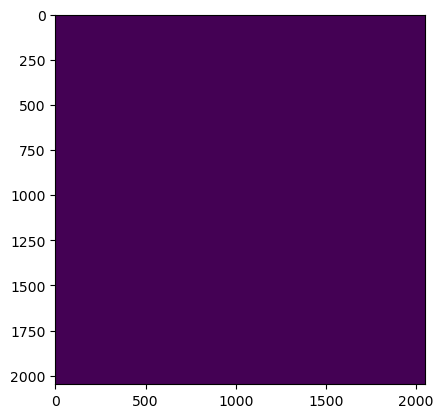

In [12]:
multiple_slice_mask(chi_array, 5, 1, plot = True)

In [28]:
    mask_list = []
    
    # Create masks for the positive values
    for i in range(5):
        start = i * (20 + 30)
        print(start)
        end = start + 20
        print(end)
        mask_list.append(ma.masked_outside(chi_array, start, end))
        print("the list of masks is now ", len(mask_list), " long")

0
20
the list of masks is now  1  long
50
70
the list of masks is now  2  long
100
120
the list of masks is now  3  long
150
170
the list of masks is now  4  long
200
220
the list of masks is now  5  long


In [30]:
combined = mask_list[0] + mask_list[4]

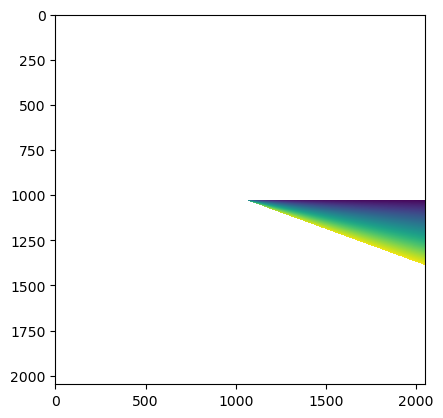

In [42]:
plt.figure()
plt.imshow(mask_list[0])

In [36]:
print(*mask_list[1].mask)

[ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True

In [61]:
import numpy.ma as ma

# Assuming chi_array is your array containing values from 0 to 180 and -180 to 0
# Create an initial mask with all True values (completely masked)
combined_mask = ma.masked_all_like(chi_array)

# Define parameters for slices
slice_width = 5
offset_between_slices = 30
num_slices = 5

combined_mask = ma.masked_outside(chi_array, 0, 5, copy=False)
combined_mask = ma.masked_outside(chi_array, 30, 35, copy=False)
# Create slices in the mask
#for i in range(num_slices):
 #   start = i * (slice_width + offset_between_slices)
  #  end = start + slice_width
   # combined_mask = ma.masked_inside(chi_array, start, end, copy=False)

# The combined_mask now contains multiple unmasked slices

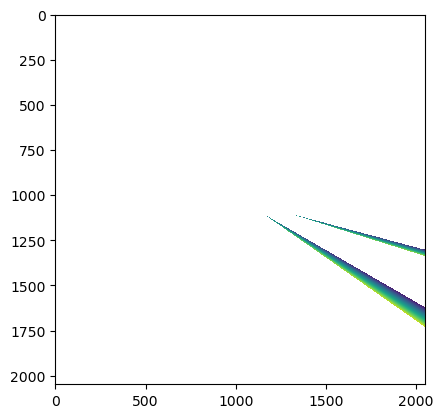

In [62]:
plt.figure()
plt.imshow(combined_mask)

In [46]:
print(*combined_mask.mask)

[ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True

In [50]:
if True in combined_mask:
    print("False is in the mask")